# <span>🖋 Title generation using LSTM </span>
<hr style="border-bottom: solid;background-color:light;color:black;">

<h2>Introduction </h2>
   
<p style="text-align:justify; padding:20px;">In this notebook we will talk about text generation. We will go through all the steps requiered to obtain a functional model. For our dataset, I have chosen "5minute-crafts-video-views-dataset". At the end of this notebook, we will try to generate some new clickbait title that we all love 😊 The notebook is devided in six steps: </p>

* [Imports](#section-1)
* [Data preparation](#section-2)
* [Building the model](#section-3)
* [Training the model](#section-4)
* [Analyse the results](#section-5)
* [Generate titles](#section-6)

<a id="section-1"></a>
# <span>1. Imports</span>
<hr style="border-bottom: solid;background-color:light;color:black;">


In [4]:
import pandas as pd 
import numpy as np
import heapq

import spacy 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 

import matplotlib.pyplot as plt


<a id="section-2"></a>
# <span>2. Data preparation</span>
<hr style="border-bottom: solid;background-color:light;color:black;">

<p style="text-align:justify;padding:20px;"> The purpose of this chapter is to gather the needed data and transform it to be usable for our neural network. To acheive these goals, we firstly need to create our dataset and analyse it. After analysis, the dataset will be transformed into sequences. The sequences will then be tokenized. A padding will be appliyed afterwards to all the sequences. </p>

<h2>2.1 Create the dataset</h2>
<p style="text-align:justify; padding:20px;">
    We first download the dataset. For our analysis the DataFrame contains alot of unusefull columns. Our model will only require the tile colmun. We will create a new dataset keeping only the "title" column. 
</p>

In [5]:
df = pd.read_csv('../input/5minute-crafts-video-views-dataset/5-Minute Crafts.csv')
titles = df[['title']]

<h2>2.2 Preprocessing</h2>
<p style="text-align:justify; padding:20px;">
    For better results, we will do a little preprocessing. By looking at the data, we can see that most titles can be devided into two sections = "||". We are going to split the titles according to this separator. For now we will only keep the left part. However, the right part could also be used has a title independently.
</p>


In [6]:
titles.head(10)

,title
0,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...
1,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...
2,HELPFUL LIFE HACKS FOR YOUR HOUSE
3,USEFUL HACKS FOR YOUR HOME || Simple Tips That...
4,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...
5,100+ HACKS & GADGETS FOR COOL PARENTS
6,30 BEST HACKS FOR EVERY LIFE SITUATION
7,KID'S ROOM MAKEOVER IDEAS || Awesome Home Deco...
8,Brilliant Clothing Hacks For Adults and Their ...
9,BRILLIANT LIFE HACKS FOR ANY SITUATION


In [7]:
separated_titles = titles['title'].str.replace('&', 'and').str.split(' \|\| ', expand=True)
cleaned_titles = separated_titles[[0]].rename(columns={0: "title"})

In [8]:
cleaned_titles.head()

,title
0,SUPER LAZY LIFE HACKS
1,YUM! EASY SMART FOOD HACKS
2,HELPFUL LIFE HACKS FOR YOUR HOUSE
3,USEFUL HACKS FOR YOUR HOME
4,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...


In [9]:
titles = [title for title in cleaned_titles['title']]

<h2>2.3 Tokenization</h2>
<p style="text-align:justify; padding:20px;">
    One big part of NLP is tokenization. Among many things, tokenization will allow to transform your text into numbers. Neural Networks aren't able to process raw text directly. The text must be transformed into integers. There are many types of tokenizers. They all have their own specifities. 
</p>

In [10]:
# Uses the tokenizer from tensorflow
tokenizer = Tokenizer()
# The tokenizer will assign a number to every word or structure of words
tokenizer.fit_on_texts(titles)
# we calculate the length of the tokenizer (the number of different words in the dataset)
vocab_size = len(tokenizer.word_index)+1

<h2>2.4 Creating the sequences</h2>
<p style="text-align:justify; padding:20px;">
    Now that we have created our tokenizer, we well transform the titles into sequences. There are multiple ways to create sequences. If this is a topic that could interest you, feel free to write a comment or to send me a message 😊. For this notebook, this is how we created our sequences from each sentence : 
</p>
<ol>
    <li>Starter : "Just a simple sentence</li>
    <li>1st sequence : [“just”, “a”]</li>
    <li>2nd sequence : [“just”, “a”, “simple”]</li>
    <li>3rd sequence : [“just”, “a”, “simple”, “sentence”]</li>
</ol>

In [11]:
sequences = []
for title in titles:
    tokenized_title = tokenizer.texts_to_sequences([title])[0]
    for i in range(1, len(tokenized_title)):
        seq = tokenized_title[:i+1]
        sequences.append(seq)
        


<h2>2.5 Padding the sequences</h2>
<p style="text-align:justify; padding:20px;">
    Our sequences are now created. However, the neural network won't be able to handle those variations. As a solution, we will apply a padding to all the sequences. A padding consist on adding "0" values to all the sequences. There exist multiple types of paddings. We will only apply one of the most basics one "pre"
</p>

In [12]:
max_seq_len = max([len(i) for i in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_seq_len, padding='pre'))

<h2>2.6 Split the data</h2>
<p style="text-align:justify; padding:20px;">
    The data is fully prepared, we just need to split it into train and validation.
</p> 

In [13]:
# split the sequences 
train, val = train_test_split(sequences, test_size=0.2, shuffle=True)

# The last element of every sequence is the prediction
X = train[:,:-1]
y = train[:,-1]

# Instead of having a single value for y, we transform if into a vector of length vocab_size. 
# The vector is allways null expect at the position y. 
y = to_categorical(y, vocab_size)

X_val = val[:,:-1]
y_val = val[:,-1]
y_val = to_categorical(y_val, vocab_size)

<a id="section-3"></a>
# <span>3. Building the model</span>
<hr style="border-bottom: solid;background-color:light;color:black;">

<p style="text-align:justify; padding:20px;"> 
    In this model architecture, we are mainly going to focus on two main features.
</p>

<p style="text-align:justify; padding:20px;">
    <b>Embedding :</b> Usually in NLP, we are confronted with a large variety of words. If we apply a one hot encoding for every word in the sequence, the size of the matrix will be very large. The matrix would be sparced since it would be formed by a lot of zeros. Word Embedding is a solution to those problems. Instead of having a large vector for every token, we have a vector from a defined length. Every element of this vector can be seen has a caracteristic. The final matrix won't be sparced anymore and the size will be smaller
</p>

<p style="text-align:justify; padding:20px;">
    <b>LSTM :</b> These neurons are made of 3 gates : Forget Gate, Input Gate and Output Gate. These neurons have a memory. For every iteration, they will update their memory and try to predict the model with it. In the link below, you will find a video explaining the basics of LSTM's.
</p>

https://www.youtube.com/watch?v=QciIcRxJvsM


In [14]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim = 200, input_length=max_seq_len-1, mask_zero=True))
model.add(LSTM(100, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(vocab_size,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 200)           407200    
_________________________________________________________________
lstm (LSTM)                  (None, 18, 100)           120400    
_________________________________________________________________
dropout (Dropout)            (None, 18, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2036)              205636    
Total params: 813,636
Trainable params: 813,636
Non-trainable params: 0
__________________________________________________

<a id="section-4"></a>
# <span>4. Training the model</span>
<hr style="border-bottom: solid;background-color:light;color:black;">

In [15]:
history = model.fit(X, y, batch_size = 64, epochs=25, validation_data=(X_val, y_val)).history

Epoch 1/25
408/408 [==============================] - 48s 96ms/step - loss: 5.8501 - accuracy: 0.0685 - val_loss: 5.3639 - val_accuracy: 0.0799
Epoch 2/25
408/408 [==============================] - 35s 86ms/step - loss: 5.0801 - accuracy: 0.1126 - val_loss: 4.8880 - val_accuracy: 0.1470
Epoch 3/25
408/408 [==============================] - 36s 88ms/step - loss: 4.6459 - accuracy: 0.1589 - val_loss: 4.6359 - val_accuracy: 0.1713
Epoch 4/25
408/408 [==============================] - 35s 86ms/step - loss: 4.3790 - accuracy: 0.1901 - val_loss: 4.4520 - val_accuracy: 0.2084
Epoch 5/25
408/408 [==============================] - 36s 87ms/step - loss: 4.1574 - accuracy: 0.2143 - val_loss: 4.3126 - val_accuracy: 0.2219
Epoch 6/25
408/408 [==============================] - 36s 89ms/step - loss: 3.9810 - accuracy: 0.2372 - val_loss: 4.2230 - val_accuracy: 0.2415
Epoch 7/25
408/408 [==============================] - 36s 89ms/step - loss: 3.8385 - accuracy: 0.2504 - val_loss: 4.1427 - val_accuracy:

<a id="section-5"></a>
# <span>5. Analyse the results</span>
<hr style="border-bottom: solid;background-color:light;color:black;">

<p style="text-align:justify; padding:20px;">
    We now have a fully trained model. We can visualise the accuracy for every epochs
</p>

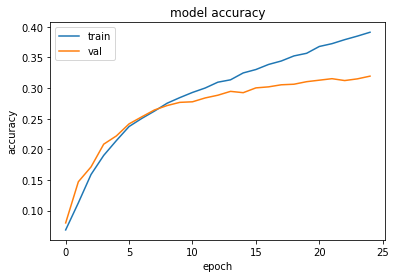

In [16]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

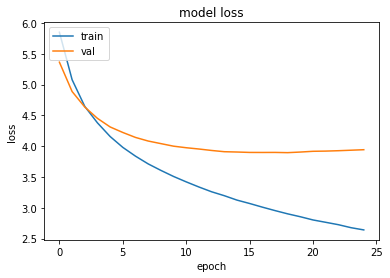

In [17]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<a id="section-6"></a>
# <span>6. Generate titles</span>
<hr style="border-bottom: solid;background-color:light;color:black;">

In [18]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    output_word = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        preds = model.predict(token_list)[0]
        next_word = heapq.nlargest(1, range(len(preds)), preds.take) 
        nxt = tokenizer.sequences_to_texts([[next_word[0]]])[0]
        output_word += ' ' + nxt
        seed_text = output_word
        
    return output_word

In [19]:
print(generate_text("How to", 4, model, max_seq_len))
print(generate_text("Amazing", 4, model, max_seq_len))

How to make a scarf diamond
Amazing life hacks for your


<p style="text-align:justify"><b>A special thanks if you have reached the end. If you have any comments or questions don't hesitate to write them in the comment section. If you liked this notebook consider giving it an upvote :) </b></p>